In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import torch
from transformers import set_seed
from torch.optim import AdamW  
from transformers import get_linear_schedule_with_warmup, Trainer, TrainingArguments
from torch.utils.data.dataset import Dataset
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
# seed_value = 24
# set_seed(seed_value)
# torch.manual_seed(seed_value)
# torch.cuda.manual_seed_all(seed_value) 

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df = df.drop(['Unnamed: 0', 'index'], axis = 1)

## чистим теги и переводим на русский

In [5]:
def clean_tags(tags):
    cleaned = re.sub(r'[\{\}]', '', tags)
    cleaned = cleaned.replace(" ", "")
    return cleaned

In [6]:
df["cleaned_tags"] = df["tags"].astype(str).apply(clean_tags)

In [7]:
all_tags = ','.join(df["cleaned_tags"].dropna())
words = all_tags.split(',')
unique_words = set(words)
print(unique_words)

{'PROMOTIONS', 'PRODUCTS_QUALITY', 'nan', 'ASSORTMENT', 'SUPPORT', 'PRICE', 'DELIVERY', 'CATALOG_NAVIGATION', 'PAYMENT'}


In [8]:
dict_tags = {
    'SUPPORT': 'поддержка',
    'DELIVERY': 'доставка',
    'PROMOTIONS': 'акции',
    'CATALOG_NAVIGATION': 'навигация по каталогу',
    'PRODUCTS_QUALITY': 'качество продукции',
    'PRICE': 'цена',
    'PAYMENT': 'оплата',
    'ASSORTMENT': 'ассортимент'
}

In [9]:
def translate_tags(tags):
    tag_list = tags.split(',')
    translated_tags = [dict_tags.get(tag, tag) for tag in tag_list]
    return ','.join(translated_tags)

In [10]:
## assessment ухудшил скор

In [11]:
df['cleaned_tags_ru'] = df['cleaned_tags'].apply(translate_tags)
df['text_tags'] = df['text'] + '.'+ df['cleaned_tags_ru'] + ' '+ df['tags'].astype(str)# + ' '+ df['assessment'].astype(str)

In [12]:
df['text_tags'][8]

'Отличное приложение спасибо большое за доставку благодарю вас.цена,акции,оплата,доставка,поддержка,ассортимент,навигация по каталогу {PRICE,PROMOTIONS,PAYMENT,DELIVERY,SUPPORT,ASSORTMENT,CATALOG_NAVIGATION}'

## длина отзывов и количество уникальных токенов

(array([1733.,  914.,  608.,  396.,  266.,  207.,  222.,  207.,   64.,
           6.]),
 array([ 1. ,  6.1, 11.2, 16.3, 21.4, 26.5, 31.6, 36.7, 41.8, 46.9, 52. ]),
 <BarContainer object of 10 artists>)

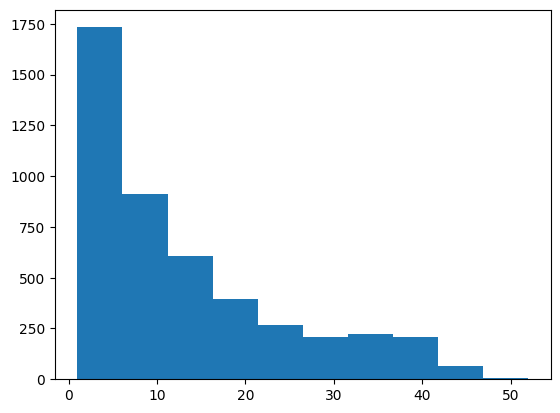

In [13]:
plt.hist(df["text"].apply(lambda x: len(x.split())))

In [14]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
unique_tokens = set()
df['text'].apply(lambda x: unique_tokens.update(tokenizer.tokenize(x)))
num_unique_tokens = len(unique_tokens)
print(f"Количество: {num_unique_tokens}")

Количество: 8629


In [15]:
test_split = 0.2
train_df, test_df = train_test_split(df, test_size=test_split)

print(f"В тренировочную выборку попало: {len(train_df)}")
print(f"В валидационную выборку попало: {len(test_df)}")

В тренировочную выборку попало: 3698
В валидационную выборку попало: 925


## отбираем лейблы

In [16]:
not_chosen_columns = ['assessment', 'text','tags', 'text_tags', 'cleaned_tags_ru', 'cleaned_tags']
label_columns = [col for col in df.columns if col not in not_chosen_columns]

df_labels_train = train_df[label_columns]
df_labels_test = test_df[label_columns]
labels_list_train = df_labels_train.values.tolist()
labels_list_test = df_labels_test.values.tolist()

In [17]:
labels_list_train = [[float(label) for label in labels] for labels in labels_list_train]
labels_list_test = [[float(label) for label in labels] for labels in labels_list_test]

## Обучение

In [18]:
train_texts = train_df['text_tags'].fillna('').astype(str).tolist()
train_labels = labels_list_train

eval_texts = test_df['text_tags'].fillna('').astype(str).tolist()
eval_labels = labels_list_test

tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2', do_lower_case=True)# павлов отработал хуже
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=512)
eval_encodings = tokenizer(eval_texts, padding="max_length", truncation=True, max_length=512)

In [19]:
class TextClassData(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [20]:
train_dataset = TextClassData(train_encodings, train_labels)
eval_dataset = TextClassData(eval_encodings, eval_labels)
model = AutoModelForSequenceClassification.from_pretrained(
    "cointegrated/rubert-tiny2",
    problem_type="multi_label_classification",
    num_labels=50
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# del model.bert.encoder.layer[0:2] не сильно влияет, улучшает только скорость

In [22]:
learning_rate = 2e-5 
weight_decay = 0.1  
train_epochs = 150 #будем специально переобучаться


optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
training_arguments = TrainingArguments(
    output_dir=".",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=train_epochs,
)


num_training_steps = len(train_dataset) // training_arguments.per_device_train_batch_size * training_arguments.num_train_epochs


scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,  
    num_training_steps=num_training_steps
)


trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    optimizers=(optimizer, scheduler), 
)


trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.379435
2,No log,0.214091
3,No log,0.160689
4,No log,0.139260
5,0.281200,0.128680
6,0.281200,0.122706
7,0.281200,0.119060
8,0.281200,0.116696
9,0.123100,0.115096
10,0.123100,0.113967


TrainOutput(global_step=17400, training_loss=0.06725109659392259, metrics={'train_runtime': 3517.6738, 'train_samples_per_second': 157.689, 'train_steps_per_second': 4.946, 'total_flos': 4116074082508800.0, 'train_loss': 0.06725109659392259, 'epoch': 150.0})

In [23]:
texts_sub = pd.read_csv('test.csv')

In [24]:
texts_sub["cleaned_tags"] = texts_sub["tags"].astype(str).apply(clean_tags)
texts_sub['cleaned_tags_ru'] = texts_sub['cleaned_tags'].apply(translate_tags)
texts_sub['text_tags'] = texts_sub['text'] + ' '+ texts_sub['cleaned_tags_ru'] + ' '+ texts_sub['tags'].astype(str)# + ' '+ texts_sub['assessment'].astype(str)
# texts_sub['text_tags'] = texts_sub['text'] + ' '+ texts_sub['cleaned_tags_ru']
# texts_sub['text_tags'] = texts_sub['text'] + ' '+ texts_sub['tags']
sub_texts = texts_sub['text_tags'].astype(str).tolist()

In [25]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [26]:
text_list = sub_texts
all_probabilities = []


for text in text_list:
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.sigmoid(logits)
    all_probabilities.append(probabilities)
    
    
all_probabilities_array = np.array([tensor.cpu().numpy() for tensor in all_probabilities])

In [27]:
new_threshold = 0.5 #0.5 150 2e5 0.1 = 46 <-лучший скор
df_submission = pd.DataFrame(columns=label_columns)


for row in all_probabilities_array:
    mask = row >= new_threshold
    if mask.any():
        thresholded_row = mask.astype(int)
    else:
        top_1_index = np.argmax(row)
        thresholded_row = np.zeros(len(label_columns), dtype=int)
        thresholded_row[top_1_index] = 1
    thresholded_row = thresholded_row.reshape(1, -1)
    df_submission = pd.concat([df_submission, pd.DataFrame(thresholded_row, columns=label_columns)], ignore_index=True)
    
    
df_submission = df_submission.astype(int)

In [28]:
df_submission['index'] = texts_sub['index']

In [29]:
new_columns = [re.sub(r'\D', '', col) for col in df_submission.columns[:-1]]  
new_columns.append('index') 

if len(new_columns) == len(df_submission.columns):
    df_submission.columns = new_columns

binary_columns = df_submission.columns[:-1]

def create_target_column(row):
    cols_with_ones = [col for col in binary_columns if row[col] == 1]
    return ' '.join(cols_with_ones)

df_submission['target'] = df_submission.apply(create_target_column, axis=1)
submission_res = df_submission[['index', 'target']]

In [30]:
submission_res

,index,target
0,3135,1 2
1,4655,12
2,22118,1 2
3,23511,0
4,45,18
...,...,...
9010,3523,3 30
9011,24925,28
9012,6327,8
9013,530,15


In [31]:
submission_res.to_csv('submission_bert.csv', index=False)

##### 